# 単純支持の片持ち梁での検討

GetFEM++を使用して単純支持の片持ち梁に荷重を与え、理論解との比較をします。

In [1]:
import getfem as gf
import numpy as np

検討するケースは次の通りです。GetFEM++において下に示す有限要素法と積分をそれぞれFEM_PRODUCTとIM_PRDOCTを使用して2次元化して使用します。

| ケース名 | 要素定式化       | 分割    | 有限要素法                     | 積分            |
| -------- | ---------------- | ------- | ------------------------------ | --------------- |
| case11   | 2次要素          | 1×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(2)   |
| case12   | 2次要素          | 2×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(2)   |
| case13   | 2次要素          | 4×4    | FEM_PK(1, 2)                   | IM_GAUSS1D(2)   |
| case14   | 2次要素          | 8×16   | FEM_PK(1, 2)                   | IM_GAUSS1D(2)   |
| case21   | 1次完全積分要素  | 1×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case22   | 1次完全積分要素  | 2×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case23   | 1次完全積分要素  | 4×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case24   | 1次完全積分要素  | 8×16   | FEM_PK(1, 1)                   | IM_GAUSS1D(2)   |
| case31   | 1次低減積分要素  | 1×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(1)   |
| case32   | 1次低減積分要素  | 2×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(1)   |
| case33   | 1次低減積分要素  | 4×4    | FEM_PK(1, 1)                   | IM_GAUSS1D(1)   |
| case34   | 1次低減積分要素  | 8×16   | FEM_PK(1, 1)                   | IM_GAUSS1D(1)   |
| case41   | 1次非適合要素    | 1×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2)   |
| case42   | 1次非適合要素    | 2×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2)   |
| case43   | 1次非適合要素    | 4×4    | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2)   |
| case44   | 1次非適合要素    | 8×16   | FEM_PK_WITH_CUBIC_BUBBLE(1, 1) | IM_GAUSS1D(2)   |

それでは、これらの有限要素法と積分法をそれぞれ設定します。メッシュを最初に設定します。モデル全体のサイズはX方向に10、Y方向に1とします。一般的に細長比（スレンダー比）が1:10であれば梁とみなせると言われています。(http://femingway.com/?p=1310)

In [2]:
x = 10.0
y = 1.0

x04 = np.arange(4+1)*x/4
x16 = np.arange(16+1)*x/16

y01 = np.arange(1+1)*y/1
y02 = np.arange(2+1)*y/2
y04 = np.arange(4+1)*y/4
y08 = np.arange(8+1)*y/8

m0104 = gf.Mesh('cartesian', x04, y01)
m0204 = gf.Mesh('cartesian', x04, y02)
m0404 = gf.Mesh('cartesian', x04, y04)
m0816 = gf.Mesh('cartesian', x16, y08)

m0104.export_to_vtk('m0104.vtk')
m0204.export_to_vtk('m0204.vtk')
m0404.export_to_vtk('m0404.vtk')
m0816.export_to_vtk('m0816.vtk')

In [3]:
def plot_vtk(filename, picturename):
    from mayavi import mlab
    mlab.init_notebook()
    vtk_file_reader = mlab.pipeline.open(filename)
    extract_edges = mlab.pipeline.extract_edges(vtk_file_reader)
    surface = mlab.pipeline.surface(extract_edges)
    axes = mlab.axes(surface)
    
    mlab.show()
    mlab.savefig(picturename)
    mlab.clf()
    from IPython.display import Image, display_png
    display_png(Image(picturename))

1×4のメッシュを表示します。

Notebook initialized with x3d backend.


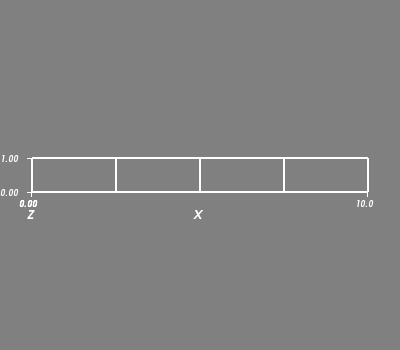

In [4]:
plot_vtk(filename = 'm0104.vtk', picturename = 'm0104.png')

2×4のメッシュを表示します。

Notebook initialized with x3d backend.


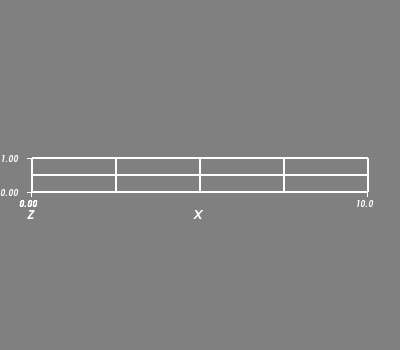

In [5]:
plot_vtk(filename = 'm0204.vtk', picturename = 'm0204.png')

4×4のメッシュを表示します。

Notebook initialized with x3d backend.


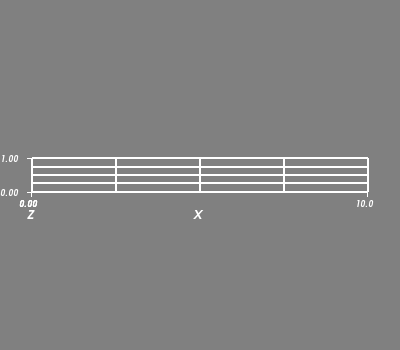

In [6]:
plot_vtk(filename = 'm0404.vtk', picturename = 'm0404.png')

8×16のメッシュを表示します。

Notebook initialized with x3d backend.


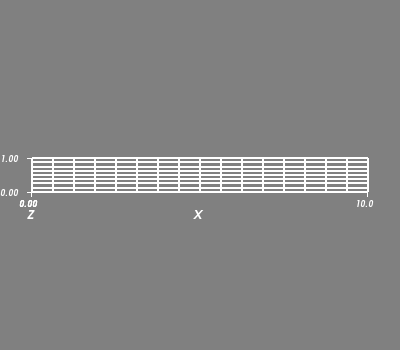

In [7]:
plot_vtk(filename = 'm0816.vtk', picturename = 'm0816.png')

各メッシュの左側面にDirichlet条件を設定するための境界領域を設定します。各メッシュの右側面にNeumann条件を設定するための境界領域を設定します。

In [8]:
flst0104 = m0104.outer_faces()
flst0204 = m0204.outer_faces()
flst0404 = m0404.outer_faces()
flst0816 = m0816.outer_faces()

fnor0104 = m0104.normal_of_faces(flst0104)
fnor0204 = m0204.normal_of_faces(flst0204)
fnor0404 = m0404.normal_of_faces(flst0404)
fnor0816 = m0816.normal_of_faces(flst0816)

tright0104 = abs(fnor0104[0, :] - 1) < 1e-14
tright0204 = abs(fnor0204[0, :] - 1) < 1e-14
tright0404 = abs(fnor0404[0, :] - 1) < 1e-14
tright0816 = abs(fnor0816[0, :] - 1) < 1e-14

tleft0104 = abs(fnor0104[0, :] + 1) < 1e-14
tleft0204 = abs(fnor0204[0, :] + 1) < 1e-14
tleft0404 = abs(fnor0404[0, :] + 1) < 1e-14
tleft0816 = abs(fnor0816[0, :] + 1) < 1e-14

fright0104 = np.compress(tright0104, flst0104, axis=1)
fright0204 = np.compress(tright0204, flst0204, axis=1)
fright0404 = np.compress(tright0404, flst0404, axis=1)
fright0816 = np.compress(tright0816, flst0816, axis=1)

fleft0104 = np.compress(tleft0104, flst0104, axis=1)
fleft0204 = np.compress(tleft0204, flst0204, axis=1)
fleft0404 = np.compress(tleft0404, flst0404, axis=1)
fleft0816 = np.compress(tleft0816, flst0816, axis=1)

right = 1
left = 2

m0104.set_region(right, fright0104)
m0204.set_region(right, fright0204)
m0404.set_region(right, fright0404)
m0816.set_region(right, fright0816)

m0104.set_region(left, fleft0104)
m0204.set_region(left, fleft0204)
m0404.set_region(left, fleft0404)
m0816.set_region(left, fleft0816)

MeshFEMオブジェクトを作成し各メッシュと有限要素法を関連付けます。

In [9]:
mfu11 = gf.MeshFem(m0104, 2)
mfu12 = gf.MeshFem(m0204, 2)
mfu13 = gf.MeshFem(m0404, 2)
mfu14 = gf.MeshFem(m0816, 2)
mfu21 = gf.MeshFem(m0104, 2)
mfu22 = gf.MeshFem(m0204, 2)
mfu23 = gf.MeshFem(m0404, 2)
mfu24 = gf.MeshFem(m0816, 2)
mfu31 = gf.MeshFem(m0104, 2)
mfu32 = gf.MeshFem(m0204, 2)
mfu33 = gf.MeshFem(m0404, 2)
mfu34 = gf.MeshFem(m0816, 2)
mfu41 = gf.MeshFem(m0104, 2)
mfu42 = gf.MeshFem(m0204, 2)
mfu43 = gf.MeshFem(m0404, 2)
mfu44 = gf.MeshFem(m0816, 2)

fem1 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 2), FEM_PK(1, 2))') # 2次要素
fem2 = gf.Fem('FEM_PRODUCT(FEM_PK(1, 1), FEM_PK(1, 1))') # 1次要素
fem3 = gf.Fem('FEM_PRODUCT(FEM_PK_WITH_CUBIC_BUBBLE(1, 1), FEM_PK_WITH_CUBIC_BUBBLE(1, 1))') # 非適合要素

mfu11.set_fem(fem1)
mfu12.set_fem(fem1)
mfu13.set_fem(fem1)
mfu14.set_fem(fem1)
mfu21.set_fem(fem2)
mfu22.set_fem(fem2)
mfu23.set_fem(fem2)
mfu24.set_fem(fem2)
mfu31.set_fem(fem2)
mfu32.set_fem(fem2)
mfu33.set_fem(fem2)
mfu34.set_fem(fem2)
mfu41.set_fem(fem3)
mfu42.set_fem(fem3)
mfu43.set_fem(fem3)
mfu44.set_fem(fem3)

積分法を定義します。

In [10]:
mim1 = gf.Integ('IM_GAUSS1D(2)')
mim2 = gf.Integ('IM_GAUSS1D(1)')

モデルを定義し、各ケースの変数を追加します。

In [11]:
md = gf.Model('real')

In [12]:
md.add_fem_variable('u11', mfu11)
md.add_fem_variable('u12', mfu12)
md.add_fem_variable('u13', mfu13)
md.add_fem_variable('u14', mfu14)
md.add_fem_variable('u21', mfu21)